In [1]:
!pip install pandas
!pip install datetime
!pip install fbprophet

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 174kB 15.4MB/s 


In [0]:
import pandas as pd

In [0]:
jfc = pd.read_csv('jfc_20130901_to_20190426.csv')
jfc['CHART_DATE'] = pd.to_datetime(jfc.CHART_DATE)

In [9]:
jfc.tail()

,Unnamed: 0,CHART_DATE,CLOSE,HIGH,LOW,OPEN,VALUE
1384,1384,2019-04-22,303.0,309.8,302.6,304.0,395456306.0
1385,1385,2019-04-23,302.2,304.4,301.4,303.0,291312114.0
1386,1386,2019-04-24,300.4,302.8,300.0,301.8,343598008.0
1387,1387,2019-04-25,303.0,307.6,301.0,301.0,274904516.0
1388,1388,2019-04-26,303.0,305.0,301.2,303.0,149795242.0


NameError: ignored

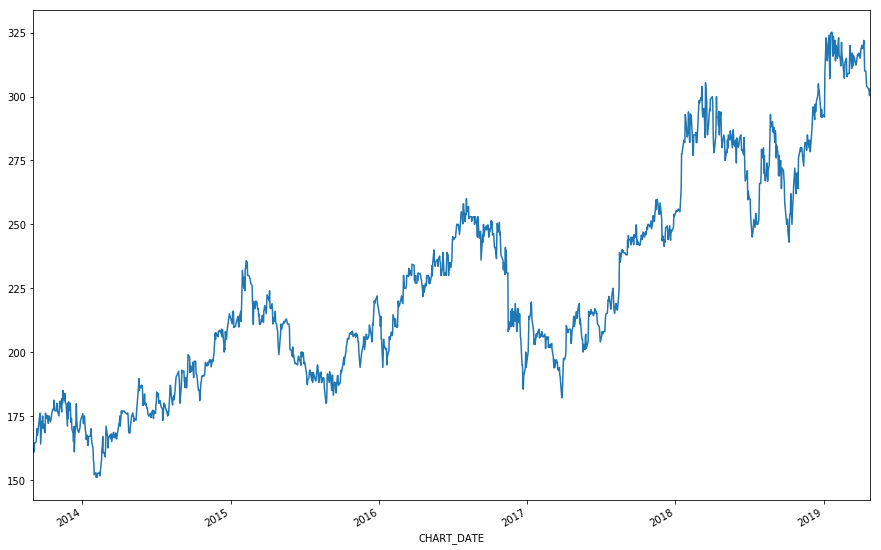

In [10]:
jfc.set_index('CHART_DATE').CLOSE.plot(figsize=(15, 10))
plt.title('Jollibee Daily Closing Price', fontsize=25)

In [11]:
from fbprophet import Prophet
#Forecasting closing prices
ts = jfc[['CHART_DATE', 'CLOSE']]
ts.columns = ['ds', 'y']
ts.head()

,ds,y
0,2013-09-02,162.1
1,2013-09-03,162.0
2,2013-09-13,168.5
3,2013-09-04,160.9
4,2013-09-05,164.5


In [0]:
HOLDOUT_START = '2019-03-01'

In [0]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True).fit(ts[ts.ds < HOLDOUT_START])
future = m.make_future_dataframe(periods=7*4*12, freq='D')

Text(0.5, 1.0, 'Jollibee: Forecasted Daily Closing Price')

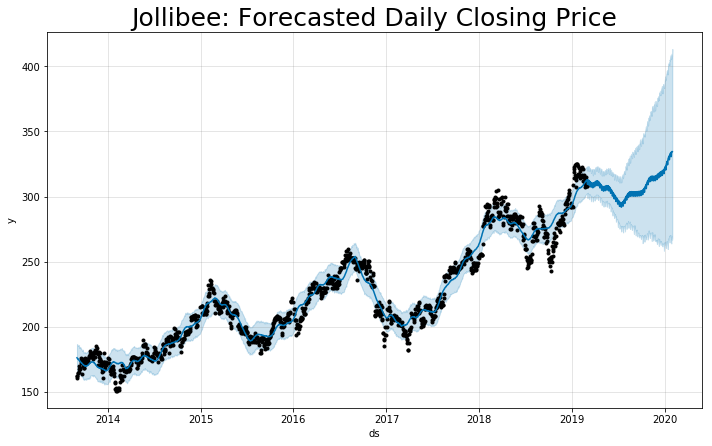

In [14]:
pred = m.predict(future)

from matplotlib import pyplot as plt
fig1 = m.plot(pred)
plt.title('Jollibee: Forecasted Daily Closing Price', fontsize=25)

In [17]:
pred_holdout = pred[(pred.ds >= HOLDOUT_START)&(pred.ds <= ts.ds.max())].set_index('ds').yhat
target_holdout = ts[ts.ds >= HOLDOUT_START].set_index('ds')
comb = pd.concat([pred_holdout, target_holdout], axis=1).dropna()
comb

,yhat,y
ds,,
2019-03-01,312.810038,309.0
2019-03-04,312.715627,309.0
2019-03-05,312.644896,309.0
2019-03-06,312.555374,316.0
2019-03-07,312.210177,320.0
2019-03-08,312.386686,317.6
2019-03-11,311.703598,311.0
2019-03-12,311.489714,317.0
2019-03-13,311.288731,316.4


In [20]:
import numpy as np
rmse_holdout = np.sqrt(comb.yhat.subtract(comb.y).pow(2).mean())
rmse_holdout

5.562907617791383

In [100]:
mae_holdout = np.mean(np.abs(comb.yhat.subtract(comb.y)))
mae_holdout

5.136952247536195

Text(0.5, 1.0, 'Predicted vs Actual JFC Closing Price \n Validation Set RMSE: 5.56')

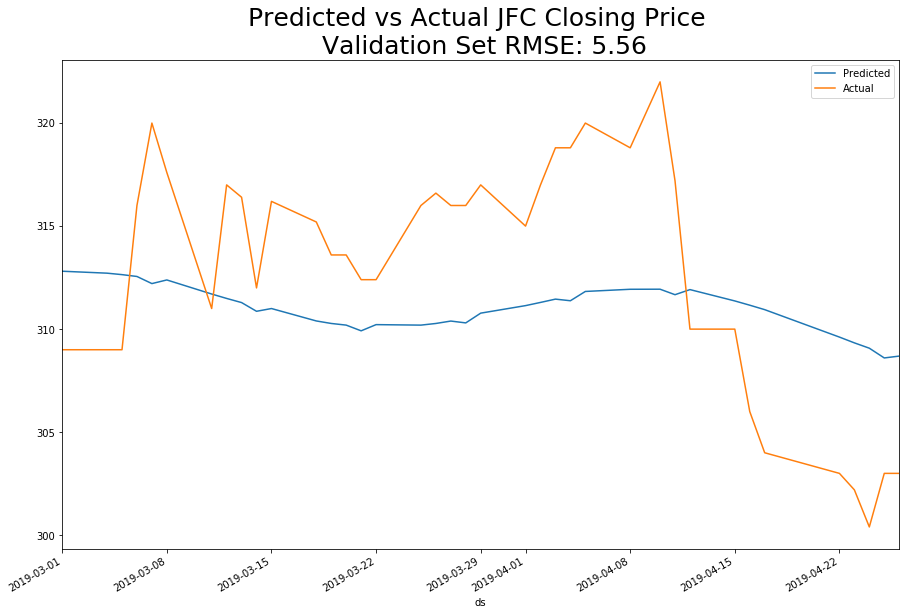

In [24]:
comb.columns = ['Predicted', 'Actual']
comb.plot(figsize=(15, 10))
plt.title('Predicted vs Actual JFC Closing Price \n Validation Set RMSE: {}'.format(round(rmse_holdout, 2)), fontsize=25)

In [0]:
# Advanced diagnostics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial=f'{ts.shape[0] - 30} days', horizon = '30 days')

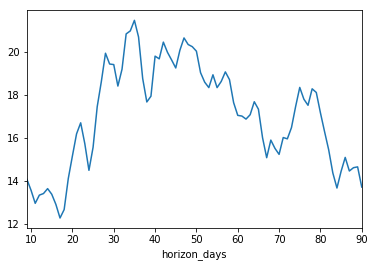

In [73]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p['horizon_days'] = df_p.horizon.dt.days
df_p.set_index('horizon_days').mae.plot()

In [0]:
# Assess accuracy
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
mean_absolute_percentage_error(y_true, y_pred)

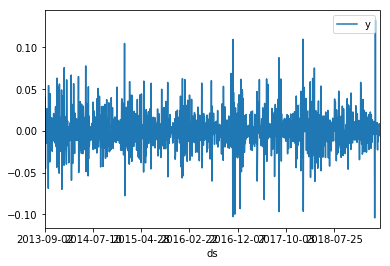

In [19]:
#Plotting returns of JFC
ts_pct = ts.set_index('ds').pct_change()
ts_pct.plot()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f137a1a5240>]],
      dtype=object)

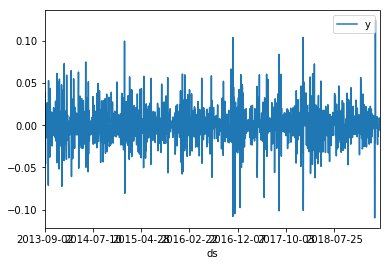

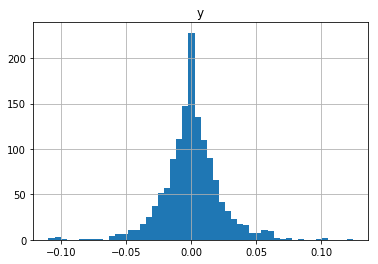

In [20]:
#Plotting log returns of JFC
import numpy as np

ts_pct = np.log(ts.set_index('ds').pct_change() + 1)
ts_pct.plot()

ts_pct.hist(bins=50)

In [0]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True).fit(ts_pct.reset_index())
future = m.make_future_dataframe(periods=7*4*12, freq='D')

Text(0.5, 1.0, 'Jollibee: Forecasted Daily Returns')

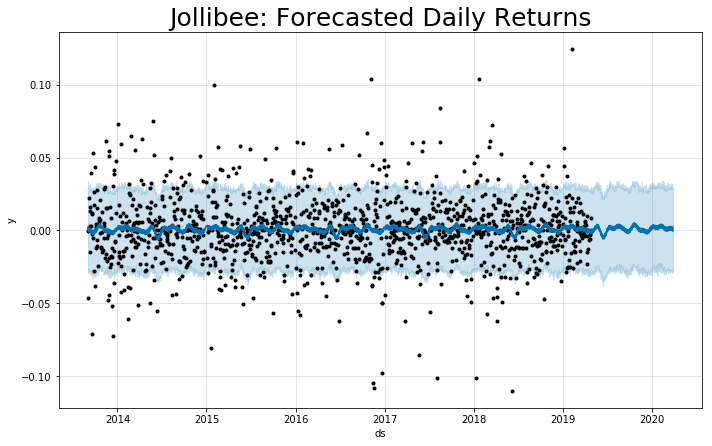

In [22]:
pred = m.predict(future)

from matplotlib import pyplot as plt
fig1 = m.plot(pred)
plt.title('Jollibee: Forecasted Daily Returns', fontsize=25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f137b7d0668>]],
      dtype=object)

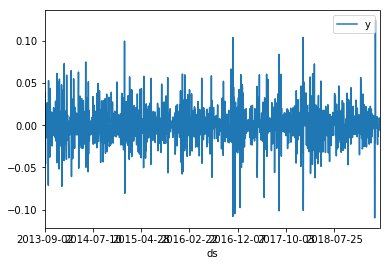

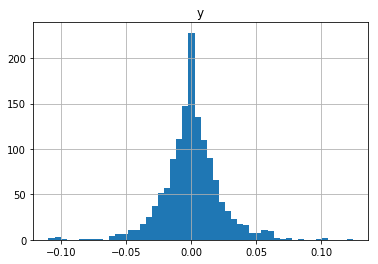

In [23]:
#log first difference of JFC
import numpy as np

ts_pct = np.log(ts.set_index('ds')).diff()
ts_pct.plot()

ts_pct.hist(bins=50)

Text(0.5, 1.0, 'Jollibee: Forecasted Daily Returns')

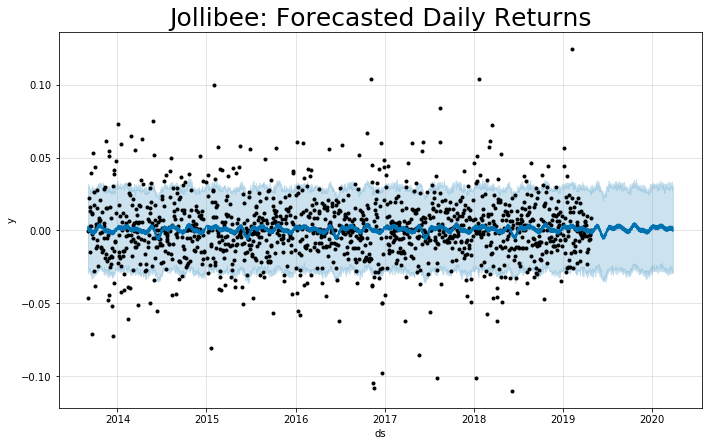

In [24]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True).fit(ts_pct.reset_index())
future = m.make_future_dataframe(periods=7*4*12, freq='D')
pred = m.predict(future)

from matplotlib import pyplot as plt
fig1 = m.plot(pred)
plt.title('Jollibee: Forecasted Daily Returns', fontsize=25)